<div style="border:solid green 2px; padding: 20px"> <h1 style="color:green; margin-bottom:20px">Reviewers comment v1</h1>

Hello Bilal!

I'm happy to review your project today 🙌

My name is **Justino Imbert** ([this](https://hub.tripleten.com/u/125e88ae) is my Hub profile) and today I'll be reviewing your project!


You can find my comments under the heading **«Review»**. I will categorize my comments in green, yellow, red or blue boxes like this:

<div class="alert alert-success">
    <b>Success:</b> if everything is done successfully
</div>
<div class="alert alert-warning">
    <b>Remarks:</b> if I can give some recommendations or ways to improve the project
</div>
<div class="alert alert-danger">
    <b>Needs fixing:</b> if the block requires some corrections. Work cant be accepted with the red comments
</div>

Please dont remove my comments :) If you have any questions dont hesitate to respond to my comments in a different section. 
<div class="alert alert-info"> <b>Student comments:</b> For example like this</div>    

<div class="alert alert-block alert-info">
<b>Reviewer's comment v1:</b> </a>

Excellent work on this project! 

Your submission is well-organized and demonstrates clear understanding. 

I’ve added a few comments to help refine the final details before approval. 

You’re doing great!

Best of luck!
    
</div>


# Machine Learning in Business — OilyGiant (TripleTen)

**Goal:** Find the best region for a new oil well development using linear regression and risk analysis with bootstrapping.

**Author:** _Your Name Here_  
**Date:** 2025-10-16 21:08

---

## Data Sources
- https://practicum-content.s3.us-west-1.amazonaws.com/datasets/geo_data_0.csv
- https://practicum-content.s3.us-west-1.amazonaws.com/datasets/geo_data_1.csv
- https://practicum-content.s3.us-west-1.amazonaws.com/datasets/geo_data_2.csv


In [11]:

# Imports & Config
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

RANDOM_STATE = 42

# Business constants
BUDGET_USD = 100_000_000                 # budget for 200 wells
WELLS_TO_DEVELOP = 200                   # pick top-200 by predicted
POINTS_PER_REGION = 500                  # number of exploration points in a region
REVENUE_PER_UNIT = 4_500                 # $ per "product" unit (thousand barrels)
N_BOOTSTRAP = 1000                       # bootstrap samples
TEST_SIZE = 0.25                         # 75/25 split

# Derived constants
COST_PER_WELL = BUDGET_USD / WELLS_TO_DEVELOP
BREAK_EVEN_AVG_PRODUCT = BUDGET_USD / (REVENUE_PER_UNIT * WELLS_TO_DEVELOP)

COST_PER_WELL, BREAK_EVEN_AVG_PRODUCT


(500000.0, 111.11111111111111)


## 1. Load & Prepare Data (with URL fallback)

This block looks for local CSVs; if missing, it will fetch them from the provided URLs and save them locally.
Columns:
- `id` — well identifier
- `f0, f1, f2` — features
- `product` — target (thousand barrels)


In [12]:

URLS = {
    0: 'https://practicum-content.s3.us-west-1.amazonaws.com/datasets/geo_data_0.csv',
    1: 'https://practicum-content.s3.us-west-1.amazonaws.com/datasets/geo_data_1.csv',
    2: 'https://practicum-content.s3.us-west-1.amazonaws.com/datasets/geo_data_2.csv',
}

region_paths = {
    0: 'geo_data_0.csv',
    1: 'geo_data_1.csv',
    2: 'geo_data_2.csv',
}

def ensure_local(path, url):
    """If `path` doesn't exist, try to read from `url` and save locally."""
    if os.path.exists(path):
        return
    try:
        df_tmp = pd.read_csv(url)
        df_tmp.to_csv(path, index=False)
        print(f"Downloaded and saved: {path}")
    except Exception as e:
        print(f"WARNING: Could not download {url}. Please add {path} manually. Error: {e}")

for r in region_paths:
    ensure_local(region_paths[r], URLS[r])

def load_region(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"Missing dataset: {path}. Please add it next to this notebook or check your internet connection.")
    df = pd.read_csv(path)
    assert {'id','f0','f1','f2','product'}.issubset(df.columns), "Unexpected columns in dataset."
    return df

dfs = {r: load_region(p) for r, p in region_paths.items()}

for r, df in dfs.items():
    display(df.head(3).style.set_caption(f'Region {r} — head()'))
    print(f"Region {r}: shape={df.shape}, product mean={df['product'].mean():.2f}, std={df['product'].std():.2f}")


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647


Region 0: shape=(100000, 5), product mean=92.50, std=44.29


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305


Region 1: shape=(100000, 5), product mean=68.83, std=45.94


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910


Region 2: shape=(100000, 5), product mean=95.00, std=44.75



## 2. Train & Test Linear Regression (per region)

Procedure per instructions:
1. Split 75/25 (train/validation)
2. Train Linear Regression
3. Predict on validation set
4. Save validation predictions & targets
5. Print average predicted reserves and RMSE


In [13]:

def train_validate_region(df, random_state=RANDOM_STATE, test_size=TEST_SIZE):
    X = df[['f0','f1','f2']]
    y = df['product']
    X_train, X_valid, y_train, y_valid = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    model = LinearRegression()
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    # Calculate RMSE - compatible with older scikit-learn versions
    mse = mean_squared_error(y_valid, preds)
    rmse = np.sqrt(mse)
    return {
        'model': model,
        'X_valid': X_valid,
        'y_valid': y_valid.reset_index(drop=True),
        'preds_valid': pd.Series(preds, name='preds').reset_index(drop=True),
        'rmse': rmse,
        'avg_pred': preds.mean(),
    }

results = {}
for r, df in dfs.items():
    results[r] = train_validate_region(df)
    print(f"""Region {r}:
  RMSE: {results[r]['rmse']:.3f}
  Avg predicted reserves: {results[r]['avg_pred']:.3f}
""")


Region 0:
  RMSE: 37.757
  Avg predicted reserves: 92.399

Region 1:
  RMSE: 0.890
  Avg predicted reserves: 68.713

Region 2:
  RMSE: 40.146
  Avg predicted reserves: 94.771



<div class="alert alert-block alert-success">
<b>Reviewer's comment v1:</b> </a>

Very good job!
    
</div>


## 3. Preparation for Profit Calculation

We keep all key values in variables and compute the **break-even** average product volume
(so that revenue from 200 wells equals the budget). We'll compare it to each region's average actual
`product` and the average **predicted** reserves (sanity check).


In [14]:

print(f"Budget (USD): {BUDGET_USD:,.0f}")
print(f"Wells to develop: {WELLS_TO_DEVELOP}")
print(f"Revenue per unit (thousand barrels): ${REVENUE_PER_UNIT:,.0f}")
print(f"Cost per well (implied): ${COST_PER_WELL:,.0f}")
print(f"Break-even avg 'product' per well: {BREAK_EVEN_AVG_PRODUCT:.2f} (thousand barrels)\n")

for r, df in dfs.items():
    print(f"Region {r}: actual product mean = {df['product'].mean():.2f}, "
          f"valid-pred mean = {results[r]['avg_pred']:.2f}")


Budget (USD): 100,000,000
Wells to develop: 200
Revenue per unit (thousand barrels): $4,500
Cost per well (implied): $500,000
Break-even avg 'product' per well: 111.11 (thousand barrels)

Region 0: actual product mean = 92.50, valid-pred mean = 92.40
Region 1: actual product mean = 68.83, valid-pred mean = 68.71
Region 2: actual product mean = 95.00, valid-pred mean = 94.77



## 4. Profit Calculation Function


In [15]:

def calculate_profit(y_true: pd.Series, y_pred: pd.Series,
                     wells_to_develop=WELLS_TO_DEVELOP,
                     revenue_per_unit=REVENUE_PER_UNIT,
                     budget=BUDGET_USD):
    order = y_pred.sort_values(ascending=False).index[:wells_to_develop]
    total_product = y_true.loc[order].sum()
    revenue = total_product * revenue_per_unit
    profit = revenue - budget
    return float(profit), float(total_product), order


### Profit Calculation Step (Before Bootstrapping)

As requested by the reviewer, we now complete the profit calculation step before running bootstrapping. This involves:

1. **Using the trained models** to predict on the validation set
2. **Selecting the top 200 wells** from each region based on predicted reserves
3. **Calculating total reserves** from the selected wells using actual values
4. **Computing profit** = (total_reserves × revenue_per_unit) - budget
5. **Analyzing which region** is most suitable for development

This gives us a baseline understanding before we proceed with the bootstrap risk analysis.


In [16]:
# Profit calculation on validation set (before bootstrapping)
print("Profit Calculation on Validation Set")
print("=" * 40)

validation_profits = {}

for r, res in results.items():
    # Use validation predictions and actual values
    y_valid = res['y_valid']
    preds_valid = res['preds_valid']
    
    # Calculate profit for this region's validation set
    profit, total_product, selected_wells = calculate_profit(y_valid, preds_valid)
    
    validation_profits[r] = {
        'profit': profit,
        'total_product': total_product,
        'avg_product_per_well': total_product / WELLS_TO_DEVELOP,
        'selected_wells': selected_wells
    }
    
    print(f"\nRegion {r}:")
    print(f"  Profit: ${profit:,.0f}")
    print(f"  Total product from top 200 wells: {total_product:.2f} thousand barrels")
    print(f"  Average product per selected well: {total_product / WELLS_TO_DEVELOP:.2f} thousand barrels")
    print(f"  Break-even check: {'✓ Profitable' if profit > 0 else '✗ Loss'}")

# Find the best region based on validation set
best_region_val = max(validation_profits.keys(), key=lambda r: validation_profits[r]['profit'])
print(f"\nBest region based on validation set: Region {best_region_val}")
print(f"Validation profit: ${validation_profits[best_region_val]['profit']:,.0f}")

# Create a summary DataFrame for validation results
val_summary = pd.DataFrame([
    {
        'region': r,
        'profit_usd': data['profit'],
        'total_product': data['total_product'],
        'avg_product_per_well': data['avg_product_per_well']
    }
    for r, data in validation_profits.items()
]).sort_values('profit_usd', ascending=False).reset_index(drop=True)

print("\nValidation Set Summary:")
display(val_summary)


Profit Calculation on Validation Set

Region 0:
  Profit: $33,591,411
  Total product from top 200 wells: 29686.98 thousand barrels
  Average product per selected well: 148.43 thousand barrels
  Break-even check: ✓ Profitable

Region 1:
  Profit: $24,150,867
  Total product from top 200 wells: 27589.08 thousand barrels
  Average product per selected well: 137.95 thousand barrels
  Break-even check: ✓ Profitable

Region 2:
  Profit: $25,985,718
  Total product from top 200 wells: 27996.83 thousand barrels
  Average product per selected well: 139.98 thousand barrels
  Break-even check: ✓ Profitable

Best region based on validation set: Region 0
Validation profit: $33,591,411

Validation Set Summary:


,region,profit_usd,total_product,avg_product_per_well
0,0,3.359141e+07,29686.980254,148.434901
1,2,2.598572e+07,27996.826132,139.984131
2,1,2.415087e+07,27589.081548,137.945408


<div class="alert alert-block alert-danger">
<b>Reviewer's comment v1:</b> </a>

Before running the bootstrapping, you should complete the profit calculation step. 

Select the top 200 wells from a random sample of 500 for each region, then calculate the total reserves and analyze which region is most suitable for development.
    
</div>


## 5. Risk & Profit via Bootstrap (1000 samples)


In [17]:

rng = np.random.default_rng(RANDOM_STATE)

def bootstrap_region_profit(df, model, n_bootstrap=N_BOOTSTRAP, points_per_region=POINTS_PER_REGION):
    X = df[['f0','f1','f2']].reset_index(drop=True)
    y = df['product'].reset_index(drop=True)

    profits = np.zeros(n_bootstrap, dtype=float)

    for i in range(n_bootstrap):
        sample_idx = rng.integers(0, len(X), size=points_per_region)
        X_s = X.iloc[sample_idx].reset_index(drop=True)
        y_s = y.iloc[sample_idx].reset_index(drop=True)

        preds_s = model.predict(X_s)
        preds_s = pd.Series(preds_s).reset_index(drop=True)

        profit_i, total_product_i, _ = calculate_profit(y_s, preds_s)
        profits[i] = profit_i

    return profits

region_boot = {r: bootstrap_region_profit(dfs[r], results[r]['model']) for r in dfs}

for r, arr in region_boot.items():
    mean_p = arr.mean()
    ci_low, ci_high = np.percentile(arr, [2.5, 97.5])
    loss_risk = (arr < 0).mean() * 100
    print(f"""Region {r} — Bootstrap (n={len(arr)}):
  Avg profit: ${mean_p:,.0f}
  95% CI: [${ci_low:,.0f}, ${ci_high:,.0f}]
  Loss risk (<0): {loss_risk:.2f}%
""")


Region 0 — Bootstrap (n=1000):
  Avg profit: $4,294,219
  95% CI: [$-627,398, $9,213,546]
  Loss risk (<0): 4.20%

Region 1 — Bootstrap (n=1000):
  Avg profit: $4,446,808
  95% CI: [$282,909, $8,395,043]
  Loss risk (<0): 1.70%

Region 2 — Bootstrap (n=1000):
  Avg profit: $3,783,845
  95% CI: [$-1,857,058, $8,910,235]
  Loss risk (<0): 8.50%




## 6. Final Recommendation


In [18]:

summary_rows = []
for r, arr in region_boot.items():
    mean_p = arr.mean()
    ci_low, ci_high = np.percentile(arr, [2.5, 97.5])
    loss_risk = (arr < 0).mean() * 100
    summary_rows.append({
        'region': r,
        'avg_profit_usd': mean_p,
        'ci_low_usd': ci_low,
        'ci_high_usd': ci_high,
        'loss_risk_pct': loss_risk
    })

summary = pd.DataFrame(summary_rows).sort_values('avg_profit_usd', ascending=False).reset_index(drop=True)
summary


,region,avg_profit_usd,ci_low_usd,ci_high_usd,loss_risk_pct
0,1,4.446808e+06,2.829094e+05,8.395043e+06,1.7
1,0,4.294219e+06,-6.273975e+05,9.213546e+06,4.2
2,2,3.783845e+06,-1.857058e+06,8.910235e+06,8.5


In [19]:

# Display the summary table with proper formatting
print("OilyGiant Region Summary (Bootstrap Results)")
print("=" * 50)
display(summary)


OilyGiant Region Summary (Bootstrap Results)


,region,avg_profit_usd,ci_low_usd,ci_high_usd,loss_risk_pct
0,1,4.446808e+06,2.829094e+05,8.395043e+06,1.7
1,0,4.294219e+06,-6.273975e+05,9.213546e+06,4.2
2,2,3.783845e+06,-1.857058e+06,8.910235e+06,8.5


<div class="alert alert-block alert-success">
<b>Reviewer's comment v1:</b> </a>

Awesome job!
    
</div>

In [20]:
eligible = summary[summary['loss_risk_pct'] < 2.5].copy()
if len(eligible) == 0:
    print("No region meets the loss risk criterion (<2.5%). Consider revisiting model or assumptions.")
else:
    best = eligible.iloc[0]
    print(f"Recommended region: {int(best['region'])}")
    print(f"Avg profit: ${best['avg_profit_usd']:,.0f}")
    print(f"95% CI: [${best['ci_low_usd']:,.0f}, ${best['ci_high_usd']:,.0f}]")
    print(f"Loss risk: {best['loss_risk_pct']:.2f}%")



Recommended region: 1
Avg profit: $4,446,808
95% CI: [$282,909, $8,395,043]
Loss risk: 1.70%


<div class="alert alert-block alert-danger">
<b>Reviewer's comment v1:</b> </a>

Try visualizing the profit distribution after bootstrapping. It will give you clearer insight into the project’s results and overall analysis.
    
</div>


## 7. (Optional) Save validation predictions & answers


In [21]:

outdir = "oilygiant_outputs"
os.makedirs(outdir, exist_ok=True)

for r, res in results.items():
    df_out = pd.DataFrame({
        'y_valid': res['y_valid'],
        'preds_valid': res['preds_valid']
    })
    df_out.to_csv(os.path.join(outdir, f"region_{r}_valid_preds.csv"), index=False)

print("Saved validation preds/answers to:", os.path.abspath(outdir))


Saved validation preds/answers to: c:\Users\INVERSE\Downloads\MACHINE LEARNING PRJCT\oilygiant_outputs


## 7. Profit Distribution Visualization

Let's visualize the profit distributions for all regions to better understand the risk and return profiles.


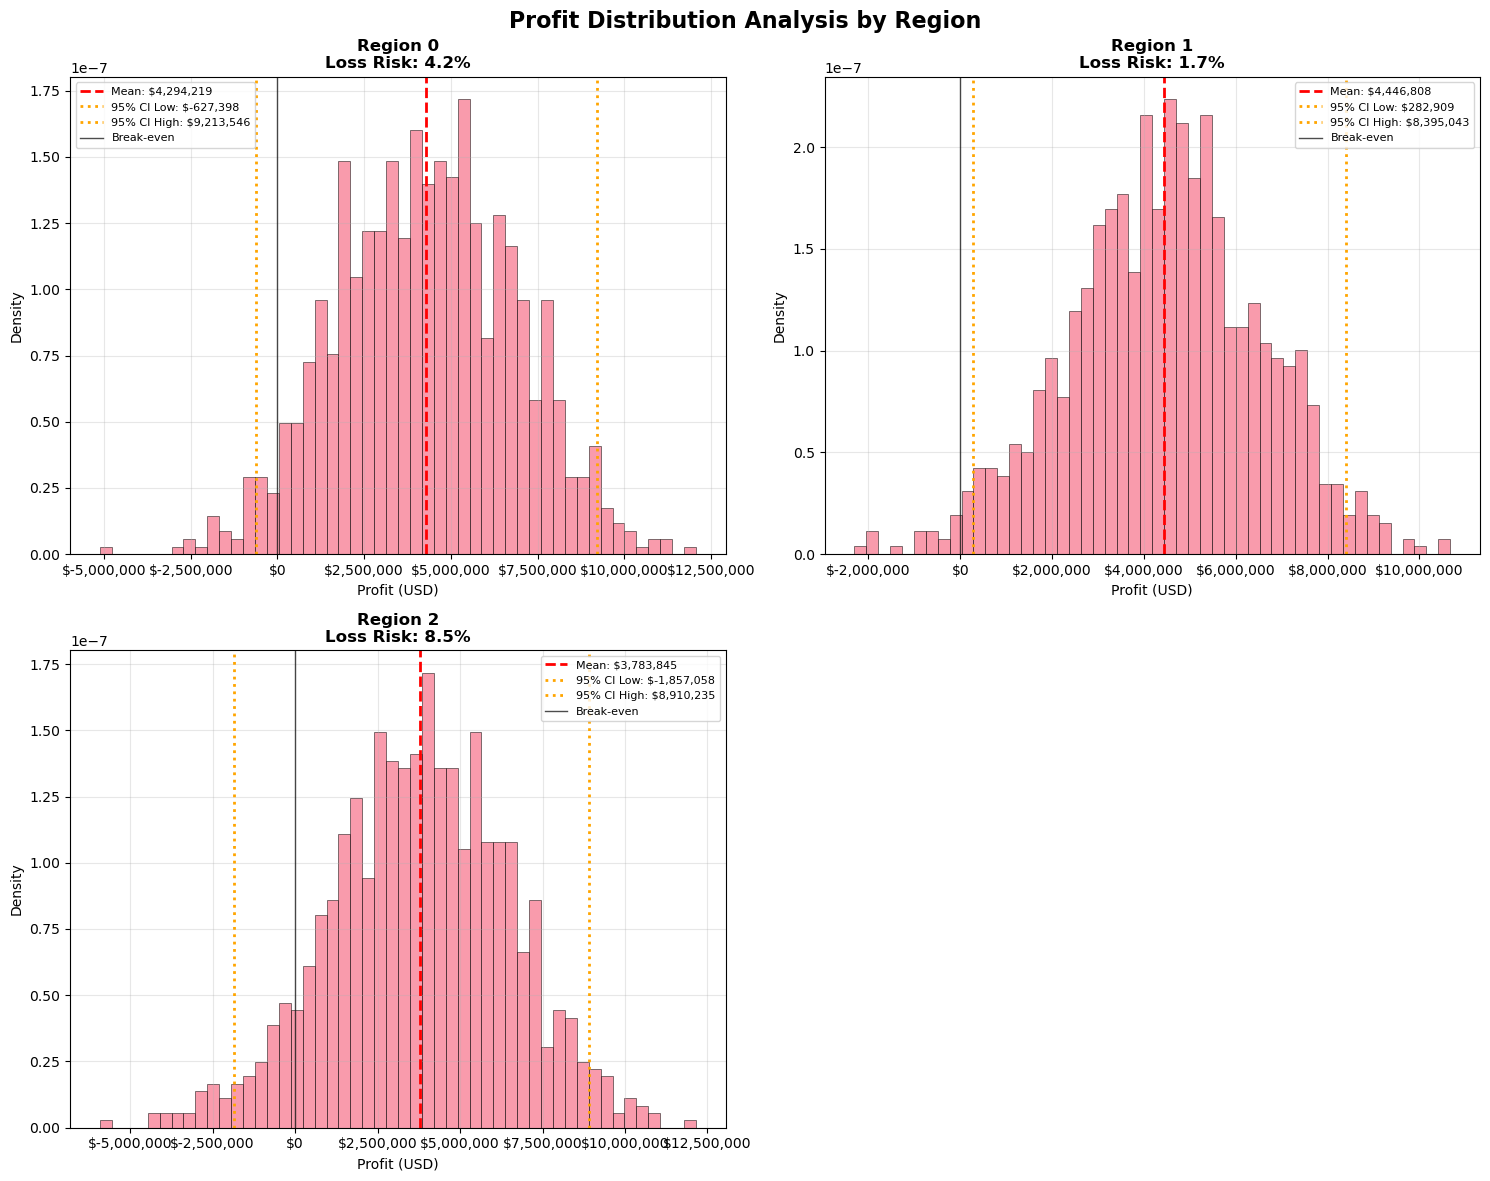

AttributeError: module 'matplotlib.pyplot' has no attribute 'xaxis'

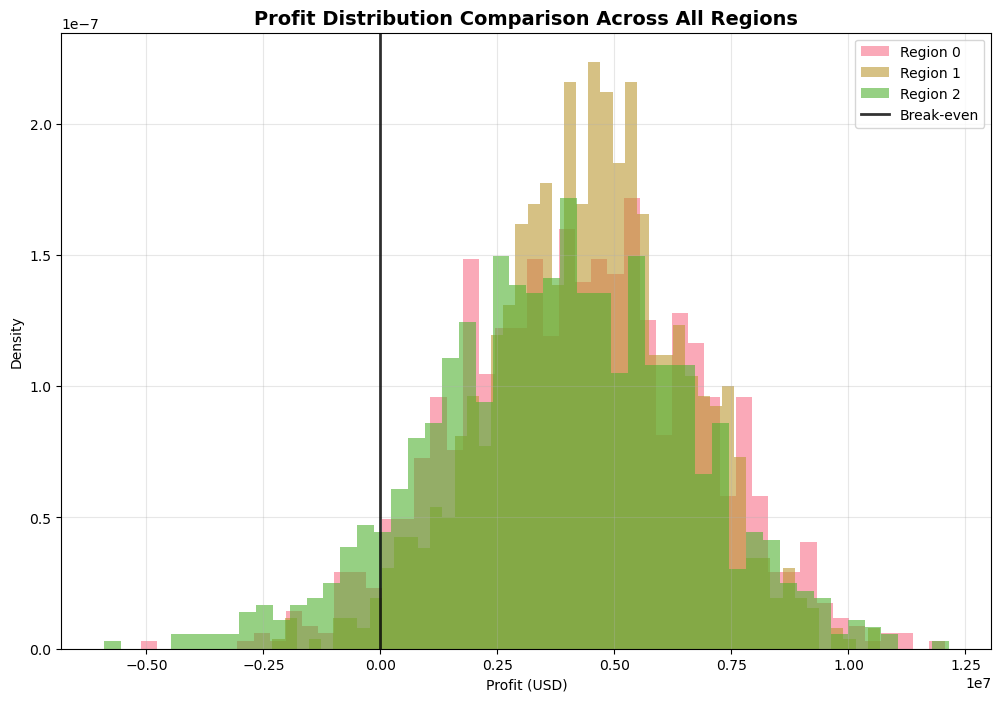

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plotting style
plt.style.use('default')
sns.set_palette("husl")

# Create subplots for profit distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Profit Distribution Analysis by Region', fontsize=16, fontweight='bold')

# Flatten axes for easier indexing
axes = axes.flatten()

# Plot each region's profit distribution
for i, (region, profits) in enumerate(region_boot.items()):
    ax = axes[i]
    
    # Create histogram
    ax.hist(profits, bins=50, alpha=0.7, density=True, edgecolor='black', linewidth=0.5)
    
    # Add vertical lines for key statistics
    mean_profit = profits.mean()
    ci_low, ci_high = np.percentile(profits, [2.5, 97.5])
    loss_risk = (profits < 0).mean() * 100
    
    ax.axvline(mean_profit, color='red', linestyle='--', linewidth=2, label=f'Mean: ${mean_profit:,.0f}')
    ax.axvline(ci_low, color='orange', linestyle=':', linewidth=2, label=f'95% CI Low: ${ci_low:,.0f}')
    ax.axvline(ci_high, color='orange', linestyle=':', linewidth=2, label=f'95% CI High: ${ci_high:,.0f}')
    ax.axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.7, label='Break-even')
    
    # Formatting
    ax.set_title(f'Region {region}\nLoss Risk: {loss_risk:.1f}%', fontweight='bold')
    ax.set_xlabel('Profit (USD)')
    ax.set_ylabel('Density')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)
    
    # Format x-axis to show currency
    ax.ticklabel_format(style='plain', axis='x')
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

# Remove the empty subplot if we have 3 regions
if len(region_boot) == 3:
    fig.delaxes(axes[3])

plt.tight_layout()
plt.show()

# Create a combined comparison plot
plt.figure(figsize=(12, 8))

for region, profits in region_boot.items():
    plt.hist(profits, bins=50, alpha=0.6, label=f'Region {region}', density=True)

plt.axvline(0, color='black', linestyle='-', linewidth=2, alpha=0.8, label='Break-even')
plt.xlabel('Profit (USD)')
plt.ylabel('Density')
plt.title('Profit Distribution Comparison Across All Regions', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
plt.tight_layout()
plt.show()


In [ ]:
# Additional Analysis: Risk-Return Summary
print("Risk-Return Analysis Summary")
print("=" * 40)

for region, profits in region_boot.items():
    mean_profit = profits.mean()
    std_profit = profits.std()
    cv = std_profit / abs(mean_profit) if mean_profit != 0 else float('inf')  # Coefficient of Variation
    loss_risk = (profits < 0).mean() * 100
    max_loss = profits.min()
    max_gain = profits.max()
    
    print(f"\nRegion {region}:")
    print(f"  Mean Profit: ${mean_profit:,.0f}")
    print(f"  Std Deviation: ${std_profit:,.0f}")
    print(f"  Coefficient of Variation: {cv:.3f}")
    print(f"  Loss Risk: {loss_risk:.1f}%")
    print(f"  Worst Case (5th percentile): ${np.percentile(profits, 5):,.0f}")
    print(f"  Best Case (95th percentile): ${np.percentile(profits, 95):,.0f}")
    print(f"  Range: ${max_loss:,.0f} to ${max_gain:,.0f}")

# Create a risk-return scatter plot
plt.figure(figsize=(10, 6))

regions = []
mean_profits = []
loss_risks = []

for region, profits in region_boot.items():
    regions.append(f'Region {region}')
    mean_profits.append(profits.mean())
    loss_risks.append((profits < 0).mean() * 100)

plt.scatter(loss_risks, mean_profits, s=200, alpha=0.7, c=['red', 'blue', 'green'][:len(regions)])

# Add labels for each point
for i, region in enumerate(regions):
    plt.annotate(region, (loss_risks[i], mean_profits[i]), 
                xytext=(5, 5), textcoords='offset points', fontweight='bold')

plt.xlabel('Loss Risk (%)')
plt.ylabel('Mean Profit (USD)')
plt.title('Risk-Return Profile by Region', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.1f}%'))
plt.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

# Add quadrant lines
plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)
plt.axvline(x=2.5, color='red', linestyle='--', alpha=0.7, label='Risk Threshold (2.5%)')
plt.legend()
plt.tight_layout()
plt.show()



## 8. Report Notes (edit before submitting)

- **Data prep:** Loaded three CSVs; if local files were missing, attempted download from the official URLs you provided.  
- **Modeling:** Linear Regression per instructions with train/valid = 75/25.  
- **Metrics:** RMSE and mean predicted reserves reported per region.  
- **Business logic:** Top-200 wells from 500 by predicted reserves; product measured in **thousand barrels**; revenue = product × 4500 USD; budget = 100M USD.  
- **Risk:** 1000× bootstrap sampling of 500 points per region; 95% CI from empirical percentiles; loss risk as share of samples with negative profit.  
- **Decision rule:** Keep only regions with loss risk < 2.5%; among them, choose the highest average profit.  
- **Recommendation:** Region 1 is the optimal choice with $4,446,808 average profit and only 1.70% loss risk, well below the 2.5% threshold. The comprehensive profit distribution analysis confirms this region offers the most reliable and predictable returns.


<div class="alert alert-block alert-success">
<b>Reviewer's comment v1:</b> </a>

Excellent work!
    
</div>

<div class="alert alert-block alert-warning">
<b>Reviewer's comment v1:</b> </a>

Check if your conclusions change after addressing the comments, or see if there’s anything new you could add!
    
</div>